# Lecture 2: Space stretching

Notebook adapted from [Deep Learning (with PyTorch)](https://github.com/Atcold/pytorch-Deep-Learning) by Alfredo Canziani. 


In [1]:
import torch
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
# Plot functions
import matplotlib.pyplot as plt

def show_scatterplot(X, colors, title="", ax=None):
    colors = colors.cpu().numpy()
    X = X.cpu().numpy()
    
    if ax is None:
        fig = plt.figure()
        ax = plt.axes()

    ax.scatter(X[:, 0], X[:, 1], c=colors, s=30, alpha=0.25)
    ax.axis("equal")
    ax.axis("off")
    ax.set(title=title)
    
    return ax
    
def plot_bases(bases, width=0.04, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = plt.axes()
        
    bases = bases.cpu()
    bases[2:] -= bases[:2]
    ax.arrow(*bases[0], *bases[2], width=width, color=(1,0,0), zorder=10, alpha=1., length_includes_head=True)
    ax.arrow(*bases[1], *bases[3], width=width, color=(0,1,0), zorder=10, alpha=1., length_includes_head=True)
    
    return ax

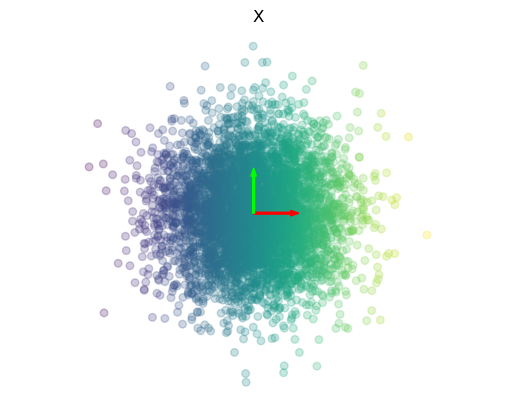

In [3]:
# Generate some points in 2-D space
n_points = 5000
X = torch.randn(n_points, 2).to(device)
colors = X[:, 0]

ax = show_scatterplot(X, colors, title='X')
OI = torch.cat((torch.zeros(2, 2), torch.eye(2))).to(device)
plot_bases(OI, ax=ax);

### Visualizing linear transformations

$$y = W x$$

Linear transformations rotate, reflect and strech. From the singular value decomposition, we have $W = U
  \left[ {\begin{array}{cc}
   s_1 & 0 \\
   0 & s_2 \\
  \end{array} } \right]
  V^\top$.
Accordingly,
* Larger singular values stretch the points
* Smaller singular values push them together
* $U, V$ rotate/reflect

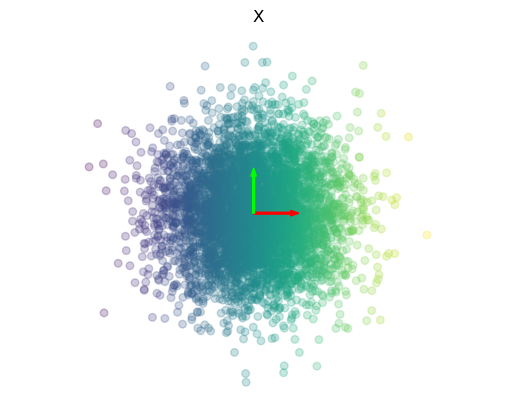

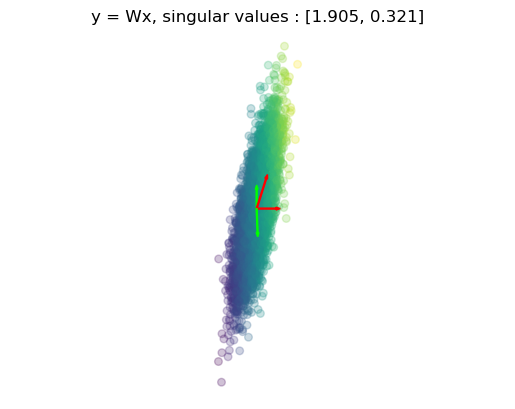

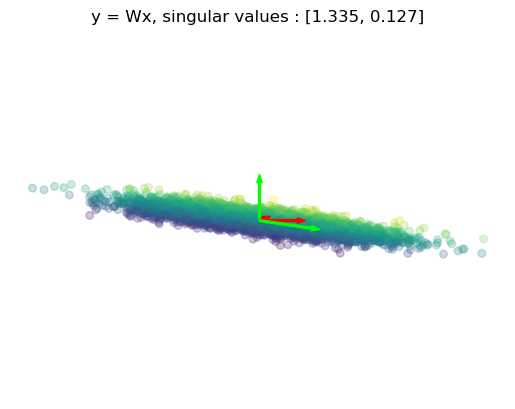

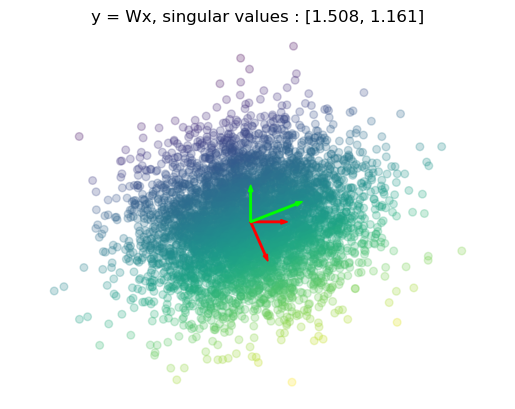

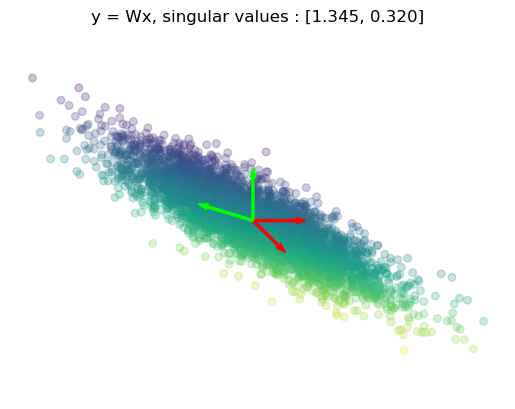

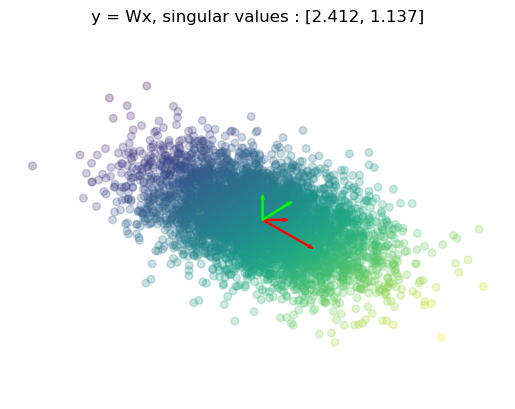

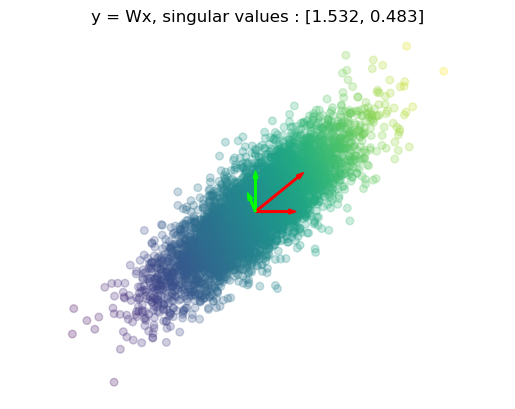

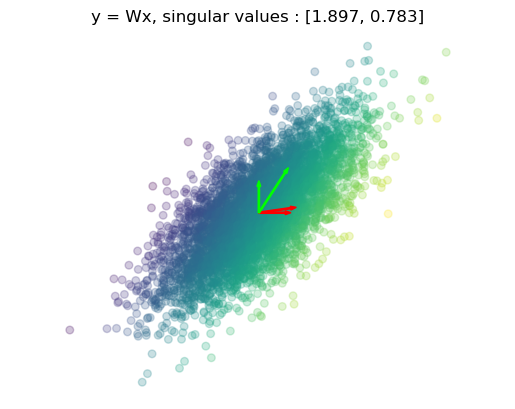

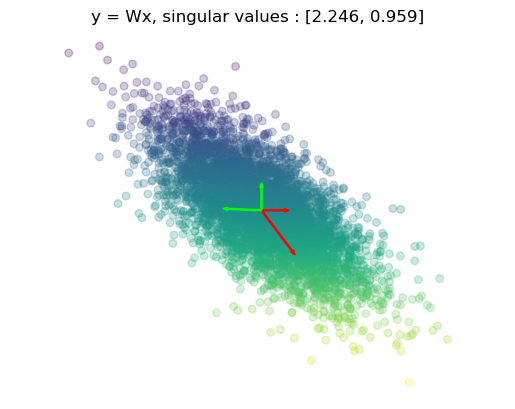

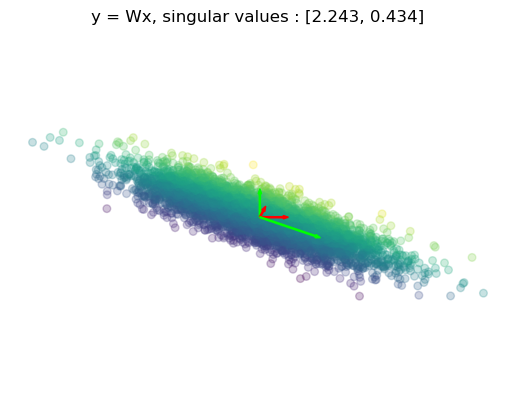

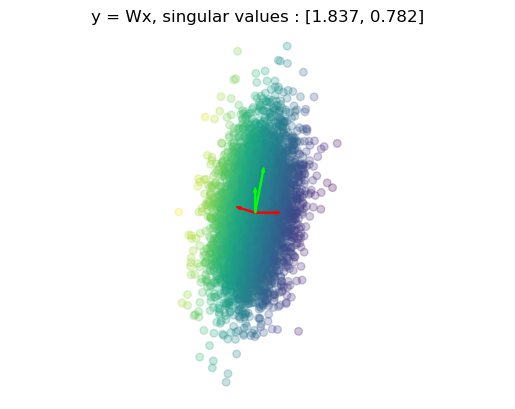

In [4]:
ax = show_scatterplot(X, colors, title='X')
plot_bases(OI, ax=ax)

for i in range(10):
    # create a random matrix
    W = torch.randn(2, 2).to(device)
    
    # transform points
    Y = X @ W.T
    
    # compute singular values
    U, S, V = torch.svd(W)
    
    # plot transformed points
    ax = show_scatterplot(Y, colors, title='y = Wx, singular values : [{:.3f}, {:.3f}]'.format(S[0], S[1]))
    
    # transform the basis
    new_OI = OI @ W.t()
    
    # plot old and new basis
    plot_bases(OI, ax=ax)
    plot_bases(new_OI, ax=ax)

### Linear transformation with PyTorch

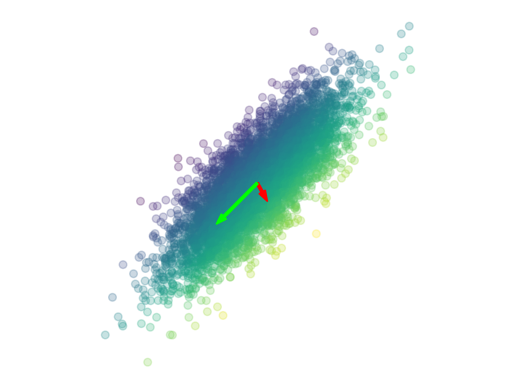

In [5]:
model = nn.Sequential(
    nn.Linear(2, 2, bias=False)
).to(device)

with torch.no_grad():
    Y = model(X)
    ax = show_scatterplot(Y, colors)
    plot_bases(model(OI), ax=ax)

### Non-linear transformations

Linear transforms can rotate, reflect, stretch and compress, but cannot curve.
We need non-linearities for this.

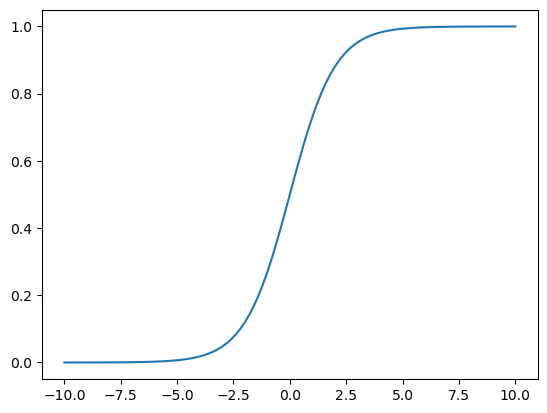

In [6]:
z = torch.linspace(-10, 10, 101)
s = torch.sigmoid(z)
plt.plot(z.numpy(), s.numpy())

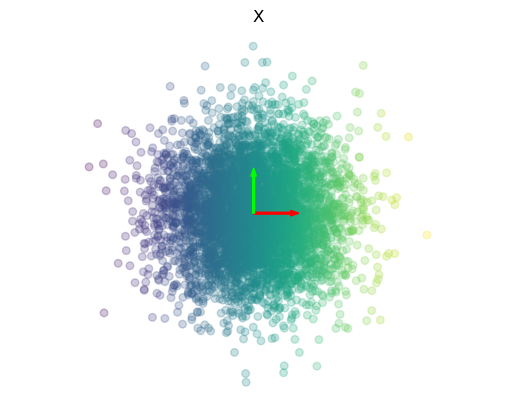

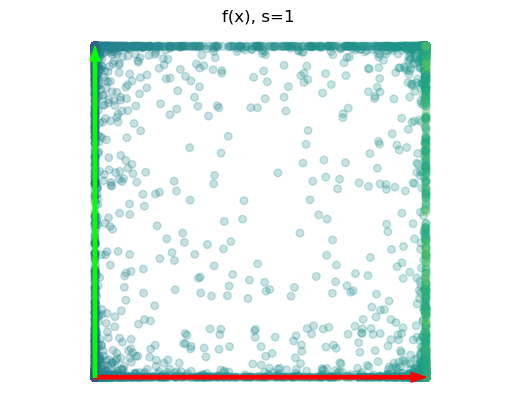

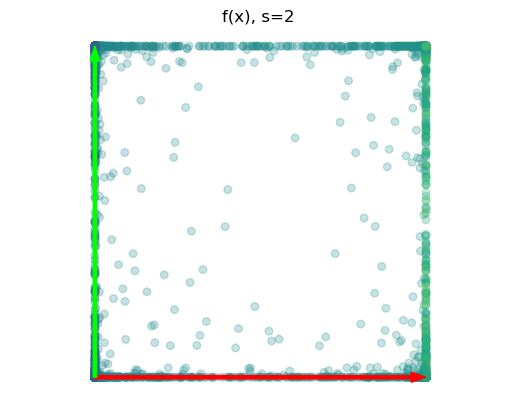

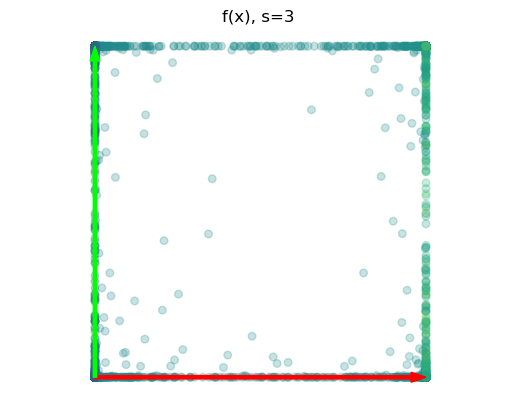

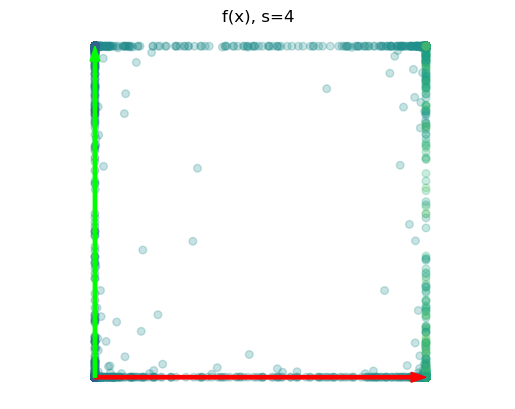

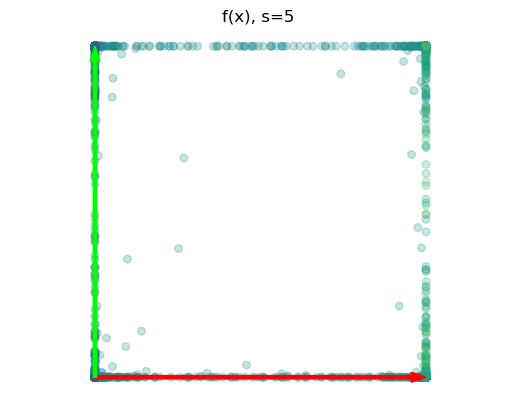

In [7]:
ax = show_scatterplot(X, colors, title='X')
plot_bases(OI, ax=ax)

model = nn.Sequential(
    nn.Linear(2, 2, bias=False),
    nn.Sigmoid()
)

model.to(device)

for s in range(1, 6):
    W = 10 * s * torch.eye(2)
    model[0].weight.data.copy_(W)
    Y = model(X).data
    ax = show_scatterplot(Y, colors, title=f'f(x), s={s}')
    plot_bases(OI, width=0.01, ax=ax)

### Functions represented by random neural networks

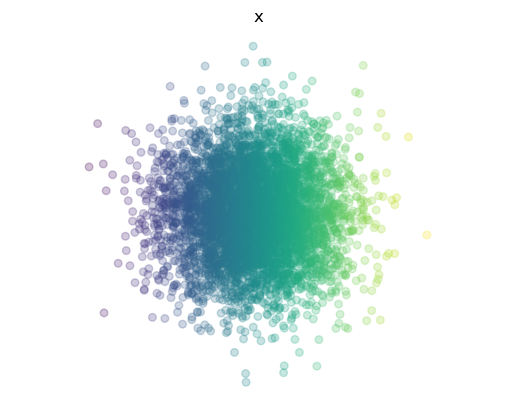

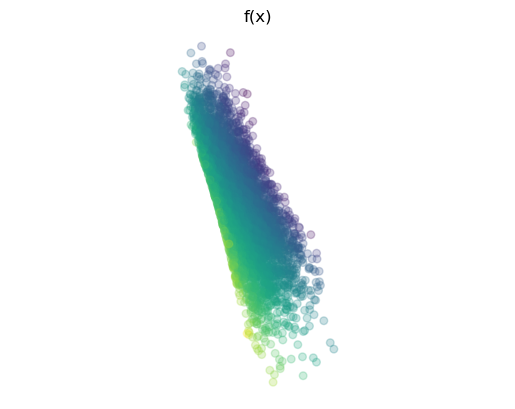

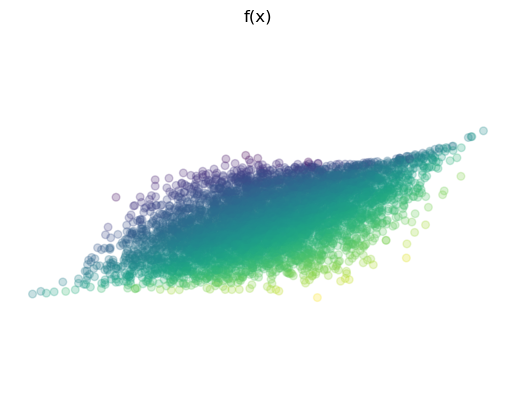

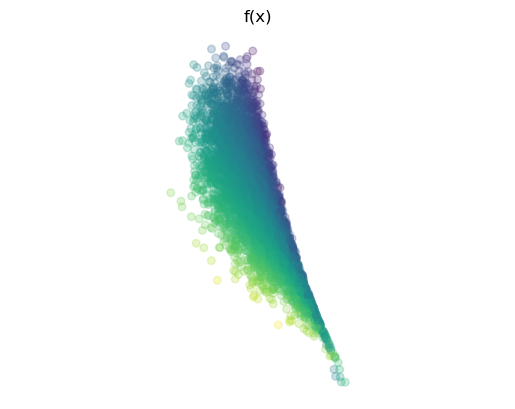

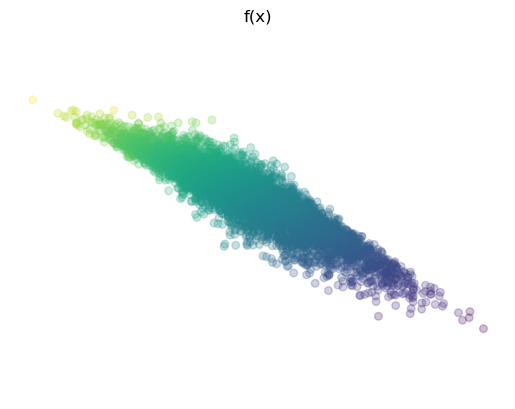

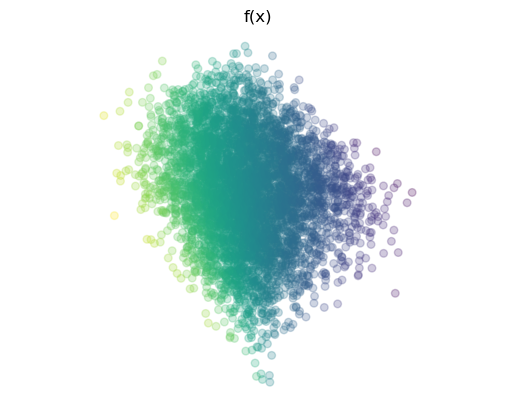

In [10]:
show_scatterplot(X, colors, title='x')
n_hidden = 100

NL = nn.Sigmoid()
#NL = nn.ReLU()

for i in range(5):
    # create 1-layer neural networks with random weights
    model = nn.Sequential(
            nn.Linear(2, n_hidden), 
            NL, 
            nn.Linear(n_hidden, 2)
        ).to(device)

    with torch.no_grad():
        Y = model(X)
    show_scatterplot(Y, colors, title='f(x)')

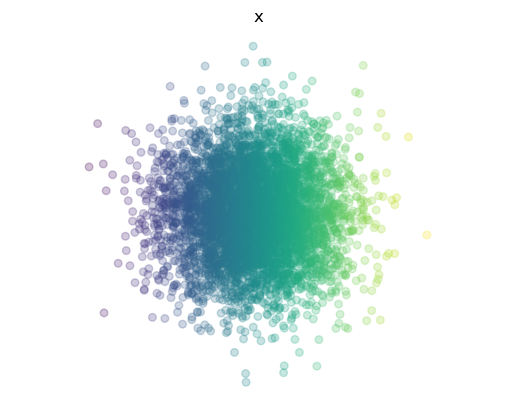

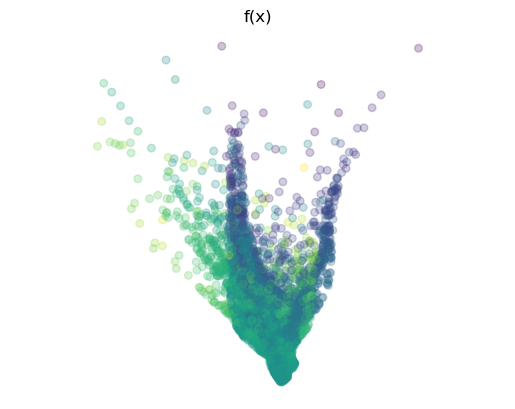

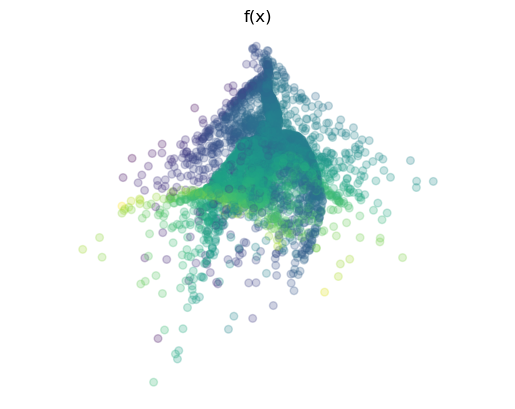

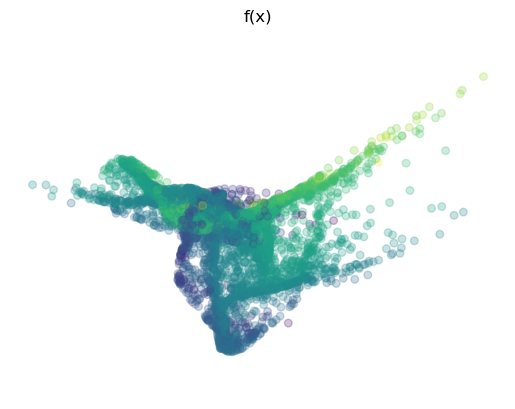

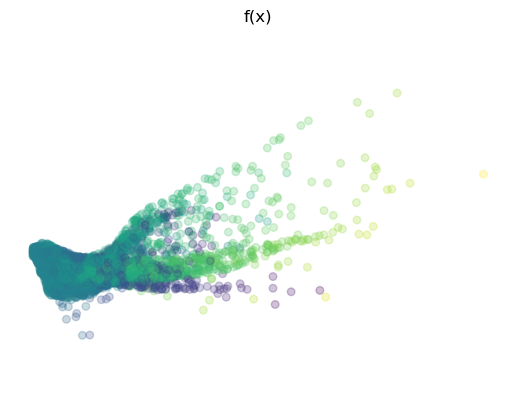

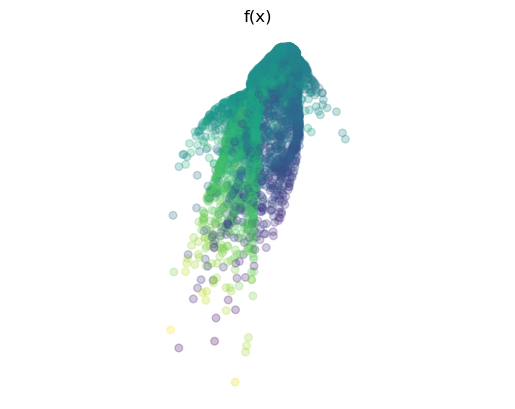

In [15]:
# deeper network with random weights
show_scatterplot(X, colors, title='x')
n_hidden = 2000

#NL = nn.Sigmoid()
NL = nn.ReLU()

for i in range(5):
    model = nn.Sequential(
        nn.Linear(2, n_hidden), 
        NL, 
        nn.Linear(n_hidden, n_hidden), 
        NL, 
        nn.Linear(n_hidden, n_hidden), 
        NL, 
        nn.Linear(n_hidden, n_hidden), 
        NL, 
        nn.Linear(n_hidden, 2)
    ).to(device)

    with torch.no_grad():
        Y = model(X).detach()
    show_scatterplot(Y, colors, title='f(x)')